Convert amplicon sequences from reference genomes to table format

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

In [2]:
# input
REF_FA = '../../../data/genome_vobs/phylo_ampl_dada2/forSeekDeep/refSeqs/{}.fasta'
AMPLS = [str(i) for i in range(62)]
# output
REF_TABLE = 'data/refs.csv'
REF_META = 'data/samples_ref.csv'

## Sequence parser

In [3]:
def parse_ref_fa(ampl):
    i = 0
    ref_meta = []
    with open(REF_FA.format(ampl)) as f:
        for line in f:
            if line.startswith('>'):
                uid = '{}.r{}'.format(ampl, i)
                samples = re.findall('genome=(.*?);', line)
            else:
                seq = line.strip()
                for sample in samples:
                    ref_meta.append({
                        's_Sample': sample,
                        'target':ampl,
                        #'s_Species': '_'.join(sample.capitalize().split('-')[:2]),
                        #'h_popUID': uid,
                        'consensus':seq
                    })
    
    return ref_meta
parse_ref_fa('0')[:2]

[{'s_Sample': 'anopheles-arabiensis-dongolascaffoldsaarad1',
  'target': '0',
  'consensus': 'CAGGCCGATGAGATGGTGGAGTTCTCCTCCGGCCTTAAGGTAAAATAAAGCTGGATTCATTccccccgtcccccccgccccTGATATGTGCTAGTGCAGCGCTATTAACCGTCGCACGCTCGATTACGCTTACTTTCAGGGCATGGC'},
 {'s_Sample': 'anopheles-melas-cm1001059ascaffoldsamelc2',
  'target': '0',
  'consensus': 'CAGGCCGATGAGATGGTGGAGTTCTCCTCCGGCCTTAAGGTAAAAACTACAGCTGGATTCAATTcccccctccccgccccTGCTATGTGCTAGCGCAGCGCTATTAACCGTCGCACGCTCGATTACGTTTACTTCCAGGGCATGGC'}]

## Convert to table

In [4]:
# parse all sequencing data
ref_data = []
for ampl in AMPLS:
    ref_data.extend(parse_ref_fa(ampl))
ref_data = pd.DataFrame(ref_data)
ref_data.sample(3)

,consensus,s_Sample,target
482,GATCTTGGCCGAGTTGTAGCGATTCTCGATGTCTTTGGTCGAGGGC...,anopheles-sinensis-sinensisscaffoldsasins2,21
455,CAAACTGCACATCGATGATGTTGGTAAACTCGCCCGGCTTCTCCAG...,anopheles-stephensi-indianscaffoldsastei2,20
2,CAGGCCGATGAGATGGTGGAGTTCTCCTCCGGCCTTAAGGTAAGGA...,anopheles-albimanus-steclachromosomesaalbs2,0


In [5]:
# write
! mkdir -p data
ref_data.to_csv(REF_TABLE, index=False)

## Sample metadata

In [6]:
# extract species data
def get_sp(sample):
    return '_'.join(sample.capitalize().split('-')[:2])

meta = pd.DataFrame(ref_data.s_Sample.sort_values().unique(), columns=['s_Sample'])
meta['Species'] = meta.s_Sample.apply(get_sp)
meta['Source'] = 'ref'
meta['Sample Set'] = 'ref'
meta.sample()

,s_Sample,Species,Source,Sample Set
2,anopheles-arabiensis-dongolascaffoldsaarad1,Anopheles_arabiensis,ref,ref


In [7]:
# write metadata
meta.to_csv(REF_META, index=False)

## Explore reference amplicon sequences

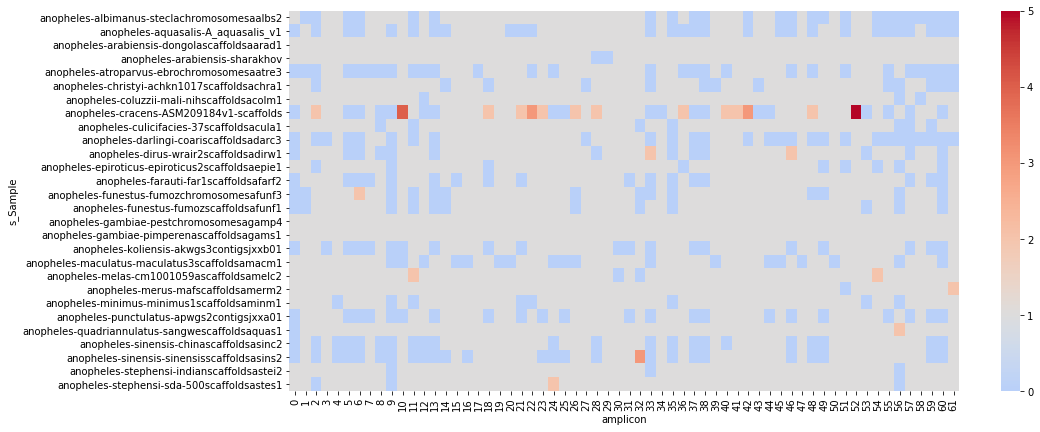

In [8]:
# marker copy number per genome, red - duplications, blue - missing data
# note high duplication level in cracens
fig, ax = plt.subplots(figsize=(15,7))
ref_data['amplicon'] = ref_data.target.astype(int)
sns.heatmap(ref_data.groupby(['s_Sample','amplicon'])['consensus'].count().unstack().fillna(0), 
            ax=ax, 
            cmap='coolwarm',
            center=1);

In [9]:
# missing target count
# affected by distance to An.gambiae and assembly quality
(62 - ref_data.groupby('s_Sample')['target'].nunique()).sort_values()

s_Sample
anopheles-arabiensis-dongolascaffoldsaarad1         0
anopheles-gambiae-pimperenascaffoldsagams1          0
anopheles-gambiae-pestchromosomesagamp4             0
anopheles-quadriannulatus-sangwescaffoldsaquas1     1
anopheles-merus-mafscaffoldsamerm2                  1
anopheles-arabiensis-sharakhov                      2
anopheles-melas-cm1001059ascaffoldsamelc2           2
anopheles-stephensi-sda-500scaffoldsastes1          3
anopheles-coluzzii-mali-nihscaffoldsacolm1          3
anopheles-stephensi-indianscaffoldsastei2           3
anopheles-culicifacies-37scaffoldsacula1            7
anopheles-minimus-minimus1scaffoldsaminm1           8
anopheles-epiroticus-epiroticus2scaffoldsaepie1     9
anopheles-funestus-fumozscaffoldsafunf1            12
anopheles-christyi-achkn1017scaffoldsachra1        13
anopheles-dirus-wrair2scaffoldsadirw1              13
anopheles-funestus-fumozchromosomesafunf3          14
anopheles-farauti-far1scaffoldsafarf2              17
anopheles-maculatus

In [10]:
# missing genotyping data in in Nyssorhynchus
x = ref_data.groupby(['s_Sample','target'])['consensus'].count().unstack().fillna(0).reset_index()
x = x[x.s_Sample.str.contains('albimanus') |
      x.s_Sample.str.contains('darlingi') |
      x.s_Sample.str.contains('aquasalis')].set_index('s_Sample')
print('Amplicons not found per species:\n{}'.format(x.sum(axis=1)))
print('Amplicons not found in all species: {}'.format((x.sum()==0).sum()))

Amplicons not found per species:
s_Sample
anopheles-albimanus-steclachromosomesaalbs2    38.0
anopheles-aquasalis-A_aquasalis_v1             34.0
anopheles-darlingi-coariscaffoldsadarc3        34.0
dtype: float64
Amplicons not found in all species: 21
